# Research Question: How many crew members the ships will need?

## Import Spark Session

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.appName("cruise").getOrCreate()

## Import Data

In [0]:
import pandas as pd

In [0]:
local_file_path = "cruise_ship_info.csv"
pandas_df = pd.read_csv(local_file_path)
df = spark.createDataFrame(pandas_df)


In [0]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [0]:
#Rename the column names
current_columns = df.columns
df_renamed = df #New data frame with renamed columns 
for old_col in current_columns:
    new_col = old_col.lower()
    df_renamed = df_renamed.withColumnRenamed(old_col, new_col)
print(df_renamed.columns)

['ship_name', 'cruise_line', 'age', 'tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'crew']


In [0]:
#This is to reanme the columns selectively

#from pyspark.sql.functions import col
#df_renamed_selective = df.select(
    #col("Ship_name").alias("ship_name"),  #Rename column
    #col("Tonnage").alias("tonnage"),      #Rename column
    #col("Age"),                           #Do not rename
    #col("Cruise_line")                    #Do not rename
    # ......
#)

In [0]:
for ship in df_renamed.head(5):
    print(ship)
    print('\n')

Row(ship_name='Journey', cruise_line='Azamara', age=6, tonnage=30.277, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)


Row(ship_name='Quest', cruise_line='Azamara', age=6, tonnage=30.277, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)


Row(ship_name='Celebration', cruise_line='Carnival', age=26, tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7)


Row(ship_name='Conquest', cruise_line='Carnival', age=11, tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1)


Row(ship_name='Destiny', cruise_line='Carnival', age=17, tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0)




## EDA

### Number of Ships by Brands

In [0]:
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt

In [0]:
df_renamed.groupBy('cruise_line').count().orderBy(desc('count')).show()

+-----------------+-----+
|      cruise_line|count|
+-----------------+-----+
|  Royal_Caribbean|   23|
|         Carnival|   22|
|         Princess|   17|
| Holland_American|   14|
|        Norwegian|   13|
|            Costa|   11|
|        Celebrity|   10|
|              MSC|    8|
|              P&O|    6|
|             Star|    6|
|Regent_Seven_Seas|    5|
|        Silversea|    4|
|           Cunard|    3|
|          Oceania|    3|
|         Windstar|    3|
|         Seabourn|    3|
|          Crystal|    2|
|           Disney|    2|
|          Azamara|    2|
|           Orient|    1|
+-----------------+-----+



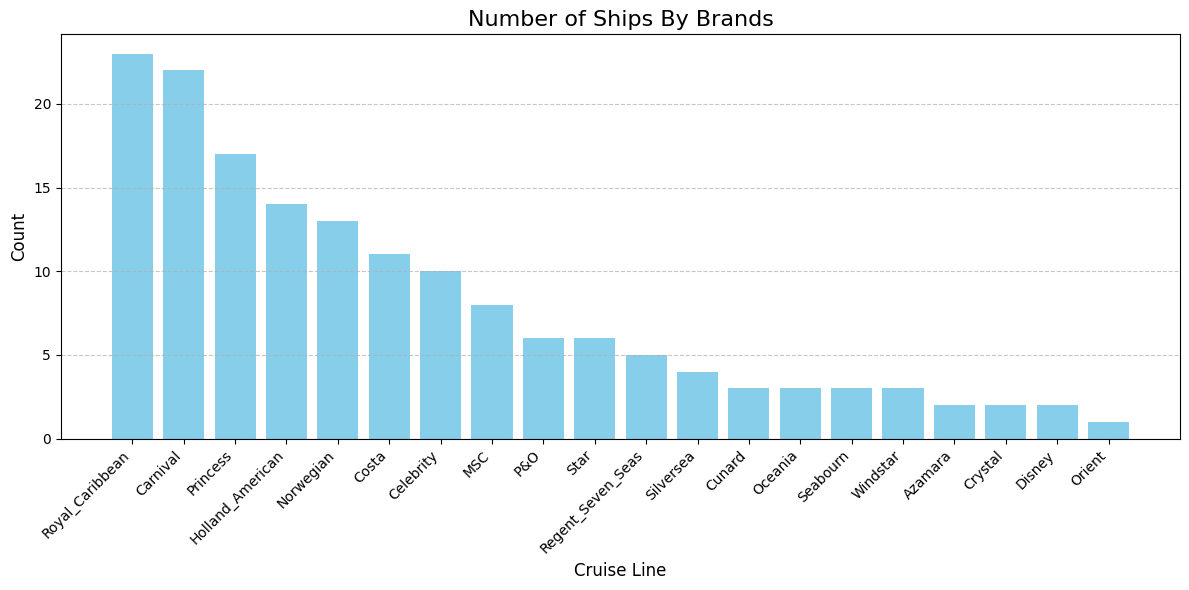

In [0]:
cruise_counts_spark = df_renamed.groupBy('cruise_line').count().orderBy(desc('count'))
cruise_counts_pandas = cruise_counts_spark.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(
    cruise_counts_pandas['cruise_line'],  
    cruise_counts_pandas['count'],       
    color = 'skyblue'
)

plt.title('Number of Ships By Brands', fontsize = 16)
plt.xlabel('Cruise Line', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout() 
plt.show()

### Correlations

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [0]:
numeric_cols = ['crew', 'age', 'tonnage', 'passengers', 'length', 'cabins', 'passenger_density']

assembler_corr = VectorAssembler(inputCols = numeric_cols, outputCol = "corr_features")
df_vector = assembler_corr.transform(df_renamed).select("corr_features")

matrix = Correlation.corr(df_vector, "corr_features", "pearson").collect()[0][0]

corr_matrix_np = matrix.toArray()

------------------------------


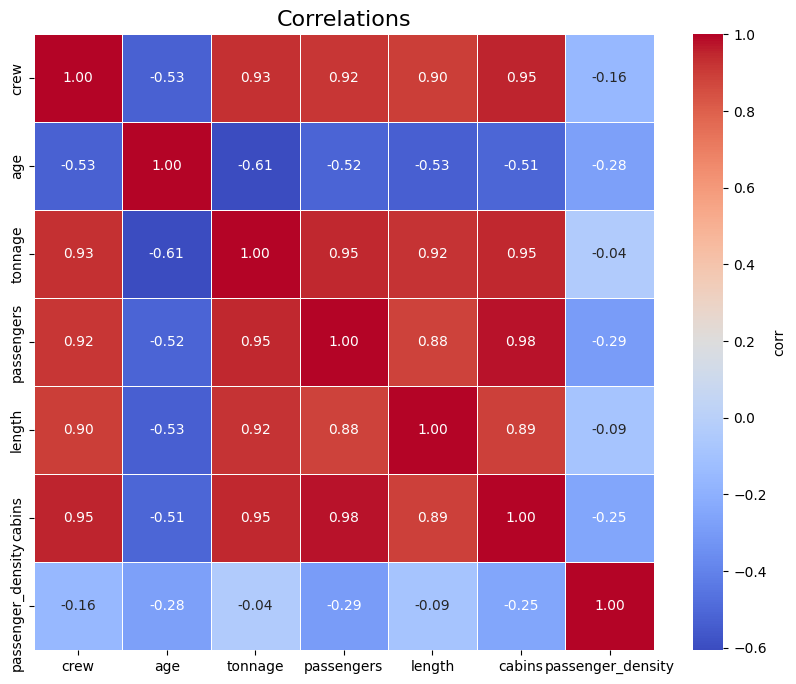

In [0]:
corr_df_pandas = pd.DataFrame(corr_matrix_np, index=numeric_cols, columns=numeric_cols)
print("-" * 30)

plt.figure(figsize = (10, 8))
sns.heatmap(
    corr_df_pandas,
    annot = True,          #Display numeric values inside the cells
    fmt = ".2f",           #Display up to two decimal places
    cmap = 'coolwarm',     #Color palette
    linewidths = .5,       #Thickness of the boundaries between cells
    cbar_kws = {'label': 'corr'} #Set the label for the color bar
)

plt.title('Correlations', fontsize=16)
plt.show()

## Preprocess Data

### Convert Data Type

In [0]:
from pyspark.ml.feature import StringIndexer #Convert a categorical column to a numeric index

In [0]:
indexer = StringIndexer(inputCol = 'cruise_line', outputCol = 'cruise_line_index')
df_index = indexer.fit(df_renamed).transform(df_renamed)
df_index.head(5)

[Row(ship_name='Journey', cruise_line='Azamara', age=6, tonnage=30.277, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_line_index=16.0),
 Row(ship_name='Quest', cruise_line='Azamara', age=6, tonnage=30.277, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, cruise_line_index=16.0),
 Row(ship_name='Celebration', cruise_line='Carnival', age=26, tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7, cruise_line_index=1.0),
 Row(ship_name='Conquest', cruise_line='Carnival', age=11, tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1, cruise_line_index=1.0),
 Row(ship_name='Destiny', cruise_line='Carnival', age=17, tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0, cruise_line_index=1.0)]

### Transform into Vector-Type Column

In [0]:
df_index.columns

['ship_name',
 'cruise_line',
 'age',
 'tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'cruise_line_index']

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler 

In [0]:
assembler = VectorAssembler(inputCols = ['age','tonnage','passengers','length','cabins'], outputCol = 'features')

In [0]:
output = assembler.transform(df_index)

In [0]:
output.select('features','crew').show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.277,6.94,...|3.55|
|[6.0,30.277,6.94,...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
|[22.0,70.367,20.5...| 9.2|
|[15.0,70.367,20.5...| 9.2|
|[23.0,70.367,20.5...| 9.2|
|[19.0,70.367,20.5...| 9.2|
|[6.0,110.239,37.0...|11.5|
|[10.0,110.0,29.74...|11.6|
|[28.0,46.052,14.5...| 6.6|
|[18.0,70.367,20.5...| 9.2|
|[17.0,70.367,20.5...| 9.2|
|[11.0,86.0,21.24,...| 9.3|
|[8.0,110.0,29.74,...|11.6|
|[9.0,88.5,21.24,9...|10.3|
|[15.0,70.367,20.5...| 9.2|
|[12.0,88.5,21.24,...| 9.3|
|[20.0,70.367,20.5...| 9.2|
+--------------------+----+
only showing top 20 rows


In [0]:
final_df = output.select('features','crew')
display(final_df)

features,crew
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""6.0"",""30.277"",""6.94"",""5.94"",""3.55""]}",3.55
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""6.0"",""30.277"",""6.94"",""5.94"",""3.55""]}",3.55
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""26.0"",""47.262"",""14.86"",""7.22"",""7.43""]}",6.7
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""11.0"",""110.0"",""29.74"",""9.53"",""14.88""]}",19.1
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""17.0"",""101.353"",""26.42"",""8.92"",""13.21""]}",10.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""22.0"",""70.367"",""20.52"",""8.55"",""10.2""]}",9.2
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""15.0"",""70.367"",""20.52"",""8.55"",""10.2""]}",9.2
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""23.0"",""70.367"",""20.56"",""8.55"",""10.22""]}",9.2
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""19.0"",""70.367"",""20.52"",""8.55"",""10.2""]}",9.2
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""6.0"",""110.239"",""37.0"",""9.51"",""14.87""]}",11.5


## Develop and Train a Model

### Split Data

In [0]:
train_data, test_data = final_df.randomSplit([0.8, 0.2])

In [0]:
train_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               111|
|   mean|  7.91108108108108|
| stddev|3.5259078396018935|
|    min|              0.59|
|    max|              21.0|
+-------+------------------+



### Develop, Train, and Evaluate a Model

In [0]:
from pyspark.ml.regression import LinearRegression

In [0]:
lr = LinearRegression(labelCol = 'crew')
trained_lr = lr.fit(train_data)
lr_result = trained_lr.evaluate(test_data)

In [0]:
print(lr_result.rootMeanSquaredError)
print(lr_result.r2)

0.9234250878520944
0.9277180112981427


In [0]:
train_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               111|
|   mean|  7.91108108108108|
| stddev|3.5259078396018935|
|    min|              0.59|
|    max|              21.0|
+-------+------------------+

